In [1]:
import pandas as pd
data=pd.read_csv('Taxi-cancellation-case (1).csv')

In [2]:
data.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/2013 22:33,NaN,0,0,1/1/2013 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/2013 12:43,NaN,0,0,1/1/2013 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/2013 0:28,1/3/2013 0:00,1,0,1/1/2013 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/2013 13:12,NaN,0,0,1/1/2013 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/2013 16:33,NaN,0,0,1/1/2013 15:07,12.926450,77.61206,12.858833,77.589127,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row#                 10000 non-null  int64  
 1   user_id              10000 non-null  int64  
 2   vehicle_model_id     10000 non-null  int64  
 3   package_id           1752 non-null   float64
 4   travel_type_id       10000 non-null  int64  
 5   from_area_id         9985 non-null   float64
 6   to_area_id           7909 non-null   float64
 7   from_city_id         3706 non-null   float64
 8   to_city_id           339 non-null    float64
 9   from_date            10000 non-null  object 
 10  to_date              5822 non-null   object 
 11  online_booking       10000 non-null  int64  
 12  mobile_site_booking  10000 non-null  int64  
 13  booking_created      10000 non-null  object 
 14  from_lat             9985 non-null   float64
 15  from_long            9985 non-null   

#Feature Analysis

In [4]:
data.drop(['row#','user_id'], axis=1, inplace=True)

In [5]:
#feature extraction
#extracting temporal information
data['from_date']=pd.to_datetime(data['from_date'])

data['booking_created']=pd.to_datetime(data['booking_created'])
#create new attribute to represent the ahead time which is the time between creating the booking and the from date

data['time_ahead']=(data['from_date'] - data['booking_created']).dt.total_seconds()

#creating new attributes representing the day of the week and the hour of the day.
data['day_of_week'] = data['from_date'].dt.dayofweek
data['hour_of_day'] = data['from_date'].dt.hour

In [6]:
import numpy as np
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [8]:
#extracting spatial information 
#creating new attributes representing the trip distance
data['distance'] = haversine_distance(data['from_lat'], data['from_long'], data['to_lat'], data['to_long'])
#creating new attributes representing if the trip is in the same area
data['within_area'] = (data['from_area_id'] == data['to_area_id']).astype(int)

In [9]:
#removing the attributes that are processed 
data.drop(['from_area_id','to_area_id', 'from_city_id', 'from_date', 'booking_created', 'to_date', 'to_city_id' ], axis=1, inplace=True)
#we are removing the city information and to_date because they have most of the instances missing.

In [10]:
#converting variables to binary indicators
data['online_booking'] = (data['online_booking'] == 1).astype(int)
data['mobile_site_booking'] = (data['mobile_site_booking'] == 1).astype(int)

In [11]:
#calculate percentage of missing values for each

missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_df = pd.DataFrame({'Column': data.columns, 'Missing Percentage': missing_percentage})
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)
print(missing_df)

                                  Column  Missing Percentage
package_id                    package_id               82.48
to_lat                            to_lat               20.91
to_long                          to_long               20.91
distance                        distance               20.91
from_lat                        from_lat                0.15
from_long                      from_long                0.15
vehicle_model_id        vehicle_model_id                0.00
travel_type_id            travel_type_id                0.00
online_booking            online_booking                0.00
mobile_site_booking  mobile_site_booking                0.00
Car_Cancellation        Car_Cancellation                0.00
time_ahead                    time_ahead                0.00
day_of_week                  day_of_week                0.00
hour_of_day                  hour_of_day                0.00
within_area                  within_area                0.00


As we can see there is around 82% of the dataset without package_id so it is safer to drop it.
Now the only attribute with missing values is the distance which is 21% which can be handled when building and running the machine building models. 

In [12]:
data.drop(['package_id'], axis=1, inplace=True)

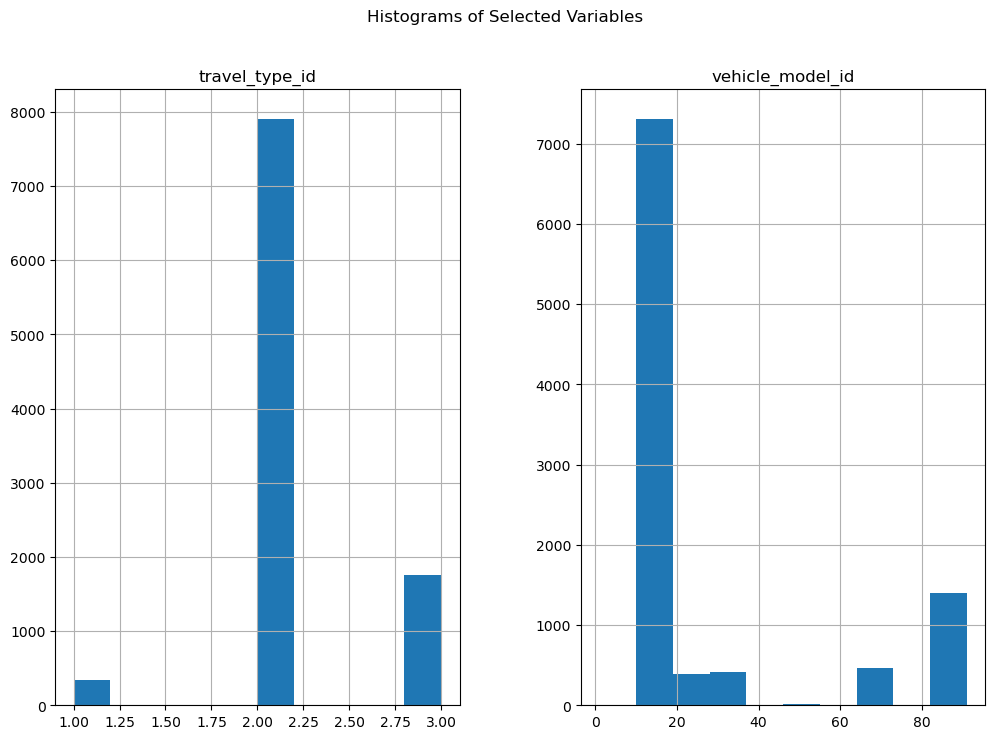

In [15]:
import matplotlib.pyplot as plt
vars = ['travel_type_id', 'vehicle_model_id']
data[vars].hist(figsize=(12, 8))
plt.suptitle("Histograms of Selected Variables")
plt.show()

As we can see vehicle_model_id is dominated by a single value, hence we can drop it. 

In [16]:
data.drop(['vehicle_model_id'], axis=1, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   travel_type_id       10000 non-null  int64  
 1   online_booking       10000 non-null  int32  
 2   mobile_site_booking  10000 non-null  int32  
 3   from_lat             9985 non-null   float64
 4   from_long            9985 non-null   float64
 5   to_lat               7909 non-null   float64
 6   to_long              7909 non-null   float64
 7   Car_Cancellation     10000 non-null  int64  
 8   time_ahead           10000 non-null  float64
 9   day_of_week          10000 non-null  int64  
 10  hour_of_day          10000 non-null  int64  
 11  distance             7909 non-null   float64
 12  within_area          10000 non-null  int32  
dtypes: float64(6), int32(3), int64(4)
memory usage: 898.6 KB


In [18]:
data.describe()

,travel_type_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,time_ahead,day_of_week,hour_of_day,distance,within_area
count,10000.000000,10000.000000,10000.00000,9985.000000,9985.000000,7909.000000,7909.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,7909.000000,10000.0
mean,2.141300,0.353300,0.04240,12.983301,77.636423,13.026217,77.640752,0.074300,1.286475e+05,3.116500,11.953700,17.255718,0.0
std,0.434917,0.478019,0.20151,0.085659,0.058667,0.113633,0.063522,0.262272,3.525605e+05,1.991413,6.092624,10.483314,0.0
min,1.000000,0.000000,0.00000,12.776630,77.386930,12.776630,77.386930,0.000000,-8.244000e+04,0.000000,0.000000,0.000000,0.0
25%,2.000000,0.000000,0.00000,12.927320,77.594800,12.951850,77.587527,0.000000,1.092000e+04,1.000000,7.000000,8.387314,0.0
50%,2.000000,0.000000,0.00000,12.969368,77.635750,12.982750,77.645030,0.000000,3.168000e+04,3.000000,11.000000,14.565165,0.0
75%,2.000000,1.000000,0.00000,13.006450,77.687790,13.199560,77.706880,0.000000,6.690000e+04,5.000000,17.000000,26.275268,0.0
max,3.000000,1.000000,1.00000,13.366072,77.786420,13.366072,77.786420,1.000000,4.399800e+06,6.000000,23.000000,53.293472,0.0


In [19]:
#as we can see within area is always 0 so we can drop it.

In [20]:
data.drop(['within_area'], axis=1, inplace=True)

# Data Analysis


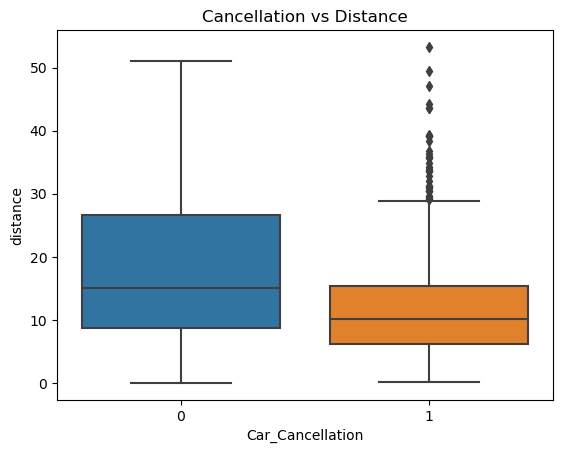

In [21]:
#data visualization
import seaborn as sns
sns.boxplot(x='Car_Cancellation', y='distance', data=data)
plt.title('Cancellation vs Distance')
plt.show()

In [22]:
#cancelled bookings have less average and median distance than non cancelled booking, however, they have a lot of outliers. 


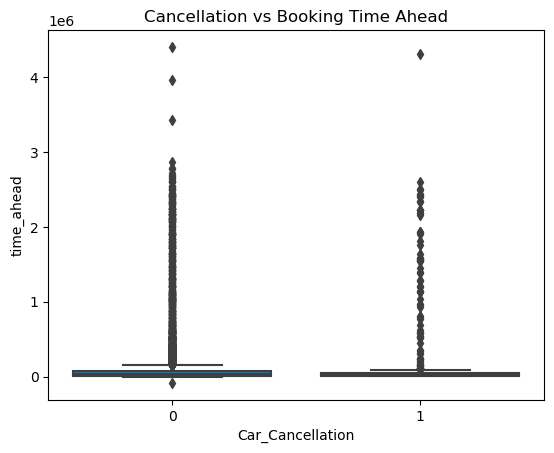

In [23]:
#data visualization


sns.boxplot(x='Car_Cancellation', y='time_ahead', data=data)
plt.title('Cancellation vs Booking Time Ahead')
plt.show()

Most of the bookings whether cancelled or not happened directly near the actual trip time.

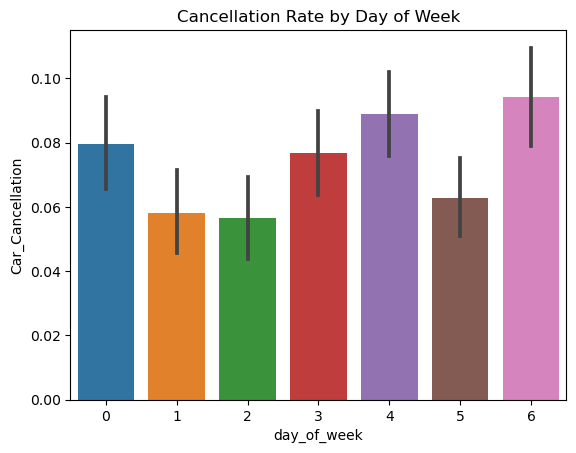

In [24]:
#data visualization

sns.barplot(y='Car_Cancellation', x='day_of_week', data=data)
plt.title('Cancellation Rate by Day of Week')
plt.show()

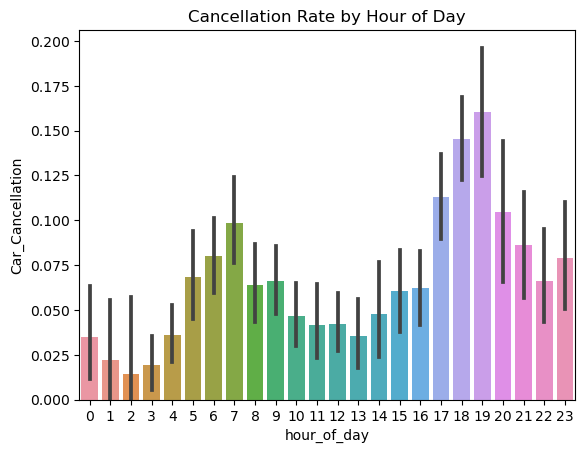

In [25]:
sns.barplot(y='Car_Cancellation', x='hour_of_day', data=data)
plt.title('Cancellation Rate by Hour of Day')
plt.show()

we can see here that the highest cancellation rates happen between hours 18-19.
There is also another peak in cancellation rate in the morning hours between 6-7.

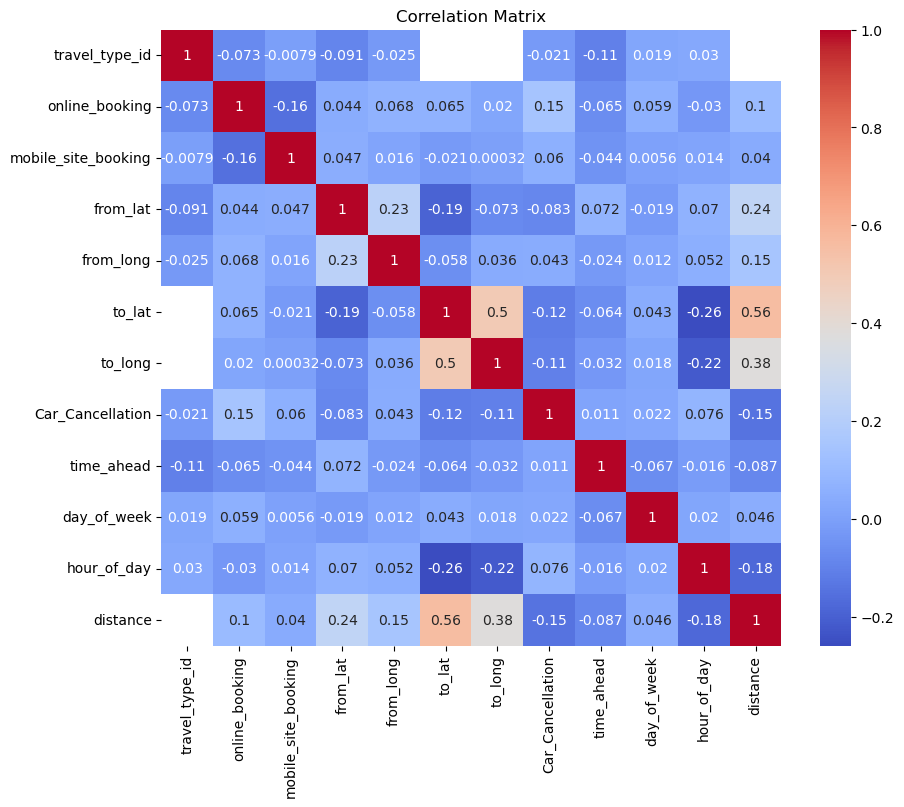

In [31]:
#correlation studies
correlation_matrix=data.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

As we can see from the correlation map there are very negligable to absent linear correlation between features and between each feature and car cancellations.
We can deduce from here that linear classifiers such as logistic regression will not perform well. 

In [32]:
#data set balance 
class_counts=data['Car_Cancellation'].value_counts()
print(class_counts)

0    9257
1     743
Name: Car_Cancellation, dtype: int64


We have 743 instances out of 10,000 with 'Car_Cancellation'=1, around 7.4% of the data is positive and the rest is negative.
Given that we are dealing with an imbalanced data set we have to maintain the imbalance ratio when splitting the data into training and validation. 

In [ ]:
#Machine Learning and model developtment and predictions

In [34]:
#splitting the data set
from sklearn.model_selection import train_test_split
X = data.drop(['Car_Cancellation'], axis=1)
y = data['Car_Cancellation']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) 
#we are doing 80/20 split with stratify enabled to ensure that the target class ratio is maintained in both splits.

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
#create pipelines for 3 different algorithms (random forest, logistic regression, naive bayes)
#each pipeline contains an imputer which fills the missing values using the mean value. We are also doing scaling of the data using the standard scaler approach.


In [39]:
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

nb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])
pipelines = {
    "Random Forest": rf_pipeline,
    "Logistic Regression": lr_pipeline,
    "Naive Bayes": nb_pipeline
    }

In [42]:
#training and evaluating the model
for ml in pipelines:
    pipelines[ml].fit(X_train, y_train)
    y_pred=pipelines[ml].predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    print(f"Metrics for {ml}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC AUC: {roc_auc}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("==============================")
    

Metrics for Random Forest:
Accuracy: 0.927
Precision: 0.5483870967741935
Recall: 0.11409395973154363
F1-Score: 0.1888888888888889
ROC AUC: 0.5532652402655557
Confusion Matrix:
[[1837   14]
 [ 132   17]]
Metrics for Logistic Regression:
Accuracy: 0.925
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC: 0.4997298757428417
Confusion Matrix:
[[1850    1]
 [ 149    0]]
Metrics for Naive Bayes:
Accuracy: 0.889
Precision: 0.17117117117117117
Recall: 0.12751677852348994
F1-Score: 0.14615384615384616
ROC AUC: 0.538906957603182
Confusion Matrix:
[[1759   92]
 [ 130   19]]


In [ ]:
#logistic regression acted as a majority classifier where it predicted all the instances but one as class 0.
#random forest: Although random forest predicted a couple of instances as class 1, the recall is very low, which shows the model is very biased towards class 0.
#naive bayes achieved relatively the best overall performance when compared to logistic regression and random forest. However, it still has a low performance to detect positive classes.

#Questions:
#what other models should perform well here?
#should we rely on probabilities and define a lower threshold to predict class 1? 
#is there a preference in terms of precision vs recall?
